<a href="https://colab.research.google.com/github/gauravsharans/202_Finals/blob/main/x_ray_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Required Libraries

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from tensorflow.compat.v1.keras import backend as K
color = sns.color_palette()

%matplotlib inline


Reproducibility is a great concern when doing deep learning. We will set checkpoints and save the sessions in order to make sure that the results are almost reproducible.

In [ ]:
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph = tf.get_default_graph(), config = session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset is divided into three sets: 1) train set    2) validation set    and 3) test set.  Let's grab the dataset   

In [ ]:
# Define path to the data directory
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/Info202_Final_Project/Data')

# Path to train directory
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

We will first go through the training dataset. We will do some analysis on that, look at some of the samples, check the number of samples for each class, etc.  Lets' do it.

Each of the above directory contains two sub-directories:
* `NORMAL`: These are the samples that describe the normal (no pneumonia) case.
* `PNEUMONIA`: This directory contains those samples that are the pneumonia cases.

In [ ]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpg')

# An empty list. We will insert the data into this list in (image_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img, 0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

train_data.shape

(4784, 2)

### How many samples for each class are there in the dataset?

1    3508
0    1276
Name: label, dtype: int64


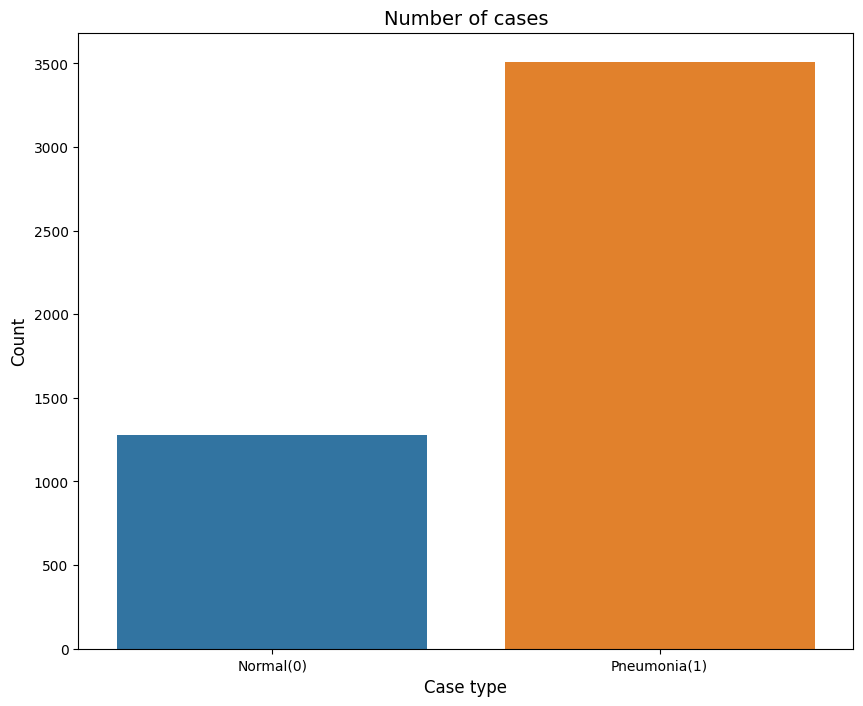

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases.

Let's look at how a normal case is different from that of a pneumonia case. We will look at samples from our training data itself.

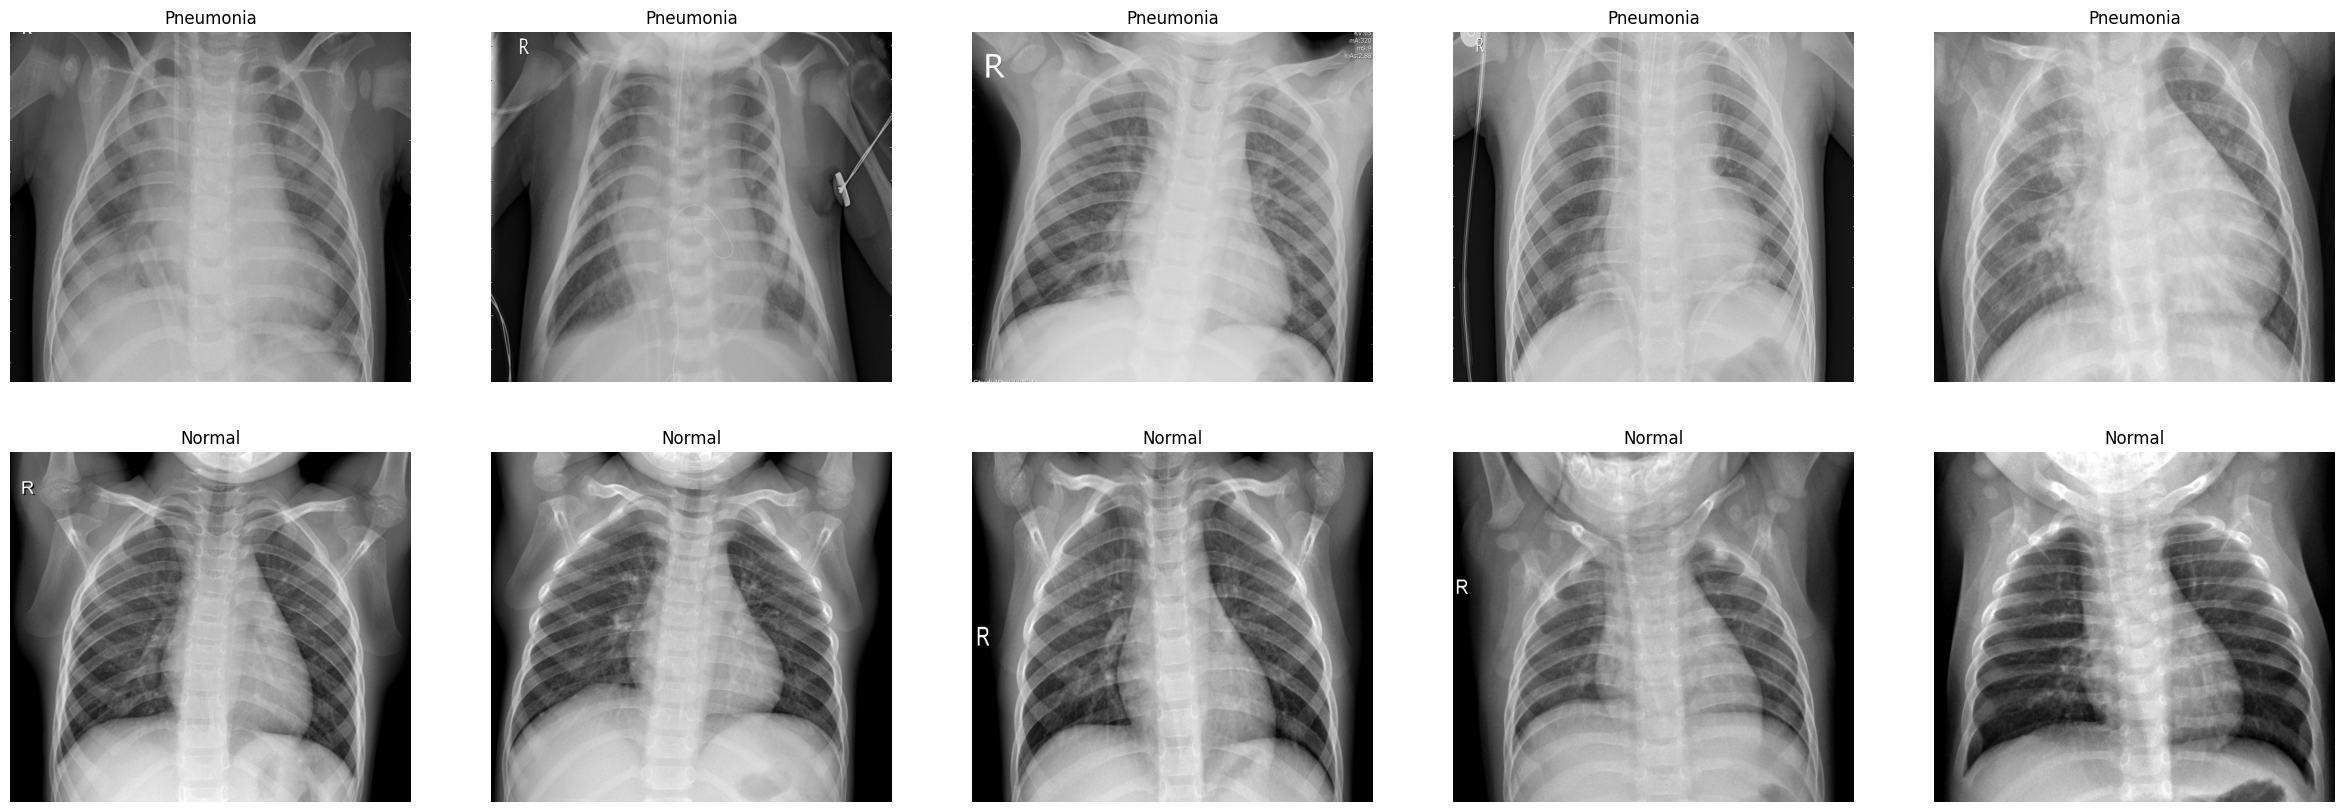

In [ ]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.

### Preparing validation data
We will be defining a generator for the training dataset later in the notebook but will define the validation set after the split here.

In [ ]:
# Lists that are going to contain validation images data and the corresponding labels

valid_data = []
valid_labels = []

valid_size = int(train_data.shape[0] * 0.2)
valid_dataset = train_data.iloc[:valid_size, ]
train_data = train_data.iloc[valid_size:, ].reset_index()

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

for image in valid_dataset['image']:
  img = cv2.imread(str(image))
  img = cv2.resize(img, (224,224))
  if img.shape[2] == 1:
      img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255
  valid_data.append(img)

for lbl in valid_dataset['label']:
  if lbl == 0:
    label = to_categorical(0, num_classes=2)
  elif lbl == 1:
    label = to_categorical(1, num_classes=2)

  valid_labels.append(label)

# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (956, 224, 224, 3)
Total number of labels: (956, 2)


## Augmentation
Data augmentation can be much more helpful where the dataset is imbalanced. We can generate different samples of undersampled class in order to try to balance the overall distribution.

At each iteration, it will take one augmentation technique out of three techniques and will apply that on the samples.

In [ ]:
# Augmentation sequence
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

### Training data generator
A simple data generator has been defined.

In [ ]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype = np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)

    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']

            # one hot encoding
            encoded_label = to_categorical(label, num_classes = 2)

            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))

            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])

            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.0

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.0
                aug_img2 = aug_img2.astype(np.float32)/255.0

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count += 2

            else:
                count += 1

            if count == batch_size - 1:
                break

        i += 1
        yield batch_data, batch_labels

        if i >= steps:
            i = 0

## Model

The highlight of my approach lies in the strategic application of transfer learning. This method involves a combination of partial transfer learning and training some parts of the model from scratch.

I initiated the initial layers with weights from a network pre-trained on ImageNet. These layers typically capture basic features like colors, shapes, and edges. Fine-tuning these pre-trained layers is more effective than starting with random weights.


In [ ]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

We will initialize the weights of first two convolutions with imagenet weights.

In [ ]:
# Open the VGG16 weight file

with h5py.File('/content/drive/MyDrive/Colab Notebooks/Info202_Final_Project/Data/VGG16_pre_trained_model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r') as f:

  # Select the layers for which you want to set weight
  w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
  model.layers[1].set_weights = [w,b]

  w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
  model.layers[2].set_weights = [w,b]

  w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
  model.layers[4].set_weights = [w,b]

  w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
  model.layers[5].set_weights = [w,b]

  model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [21]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(learning_rate = 0.001)
es = EarlyStopping(patience = 5)
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Info202_Final_Project/Data/Trained Model/best_model'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data = train_data, batch_size = batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 239 and 956


In [23]:
# # Fit the model
history = model.fit(train_data_gen, epochs = nb_epochs, steps_per_epoch = nb_train_steps,
                              validation_data = (valid_data, valid_labels),callbacks = [es, chkpt],
                              class_weight = {0:1.0, 1:0.4})

Epoch 1/20
239/239 [==============================] - 69s 265ms/step - loss: 0.0937 - accuracy: 0.9459 - val_loss: 0.2509 - val_accuracy: 0.9362
Epoch 2/20
239/239 [==============================] - 63s 262ms/step - loss: 0.0715 - accuracy: 0.9545 - val_loss: 0.2084 - val_accuracy: 0.9278
Epoch 3/20
239/239 [==============================] - 58s 242ms/step - loss: 0.0617 - accuracy: 0.9563 - val_loss: 0.3000 - val_accuracy: 0.8808
Epoch 4/20
239/239 [==============================] - 58s 241ms/step - loss: 0.0833 - accuracy: 0.9469 - val_loss: 0.2921 - val_accuracy: 0.8745
Epoch 5/20
239/239 [==============================] - 58s 241ms/step - loss: 0.0593 - accuracy: 0.9571 - val_loss: 0.2201 - val_accuracy: 0.9048
Epoch 6/20
239/239 [==============================] - 59s 245ms/step - loss: 0.0551 - accuracy: 0.9663 - val_loss: 0.2367 - val_accuracy: 0.9100
Epoch 7/20
239/239 [==============================] - 64s 267ms/step - loss: 0.0888 - accuracy: 0.9519 - val_loss: 0.1705 - val_ac

In [32]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)


test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (1172, 224, 224, 3)
Total number of labels: (1172, 2)


In [33]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

74/74 [==============================] - 4s 59ms/step - loss: 0.1940 - accuracy: 0.9283
Loss on test set:  0.19395461678504944
Accuracy on test set:  0.9283276200294495


In [34]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

74/74 [==============================] - 4s 47ms/step
(1172,)
(1172,)




We will get the confusion matrix from our predictions and see what is the recall and precision of our model.

<Figure size 640x480 with 0 Axes>

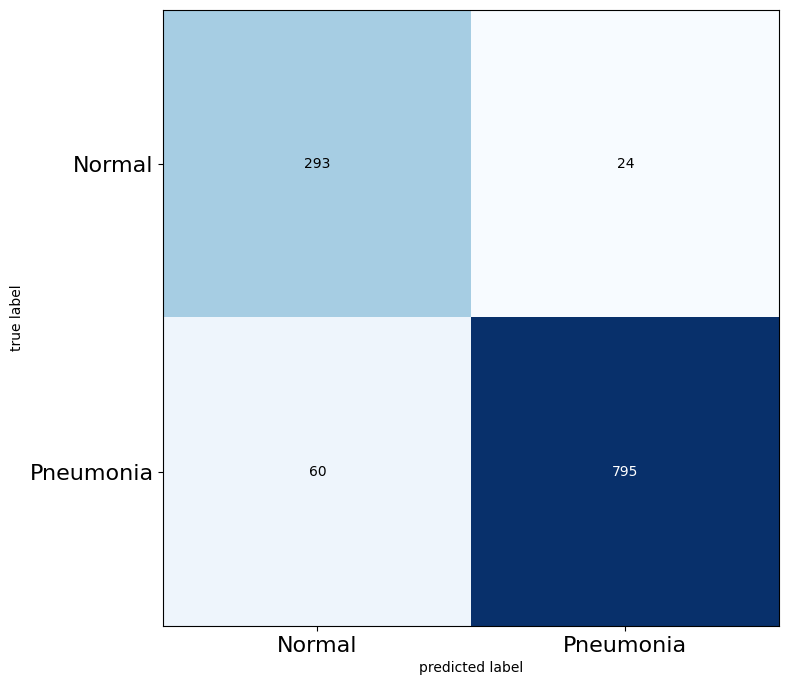

In [36]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [37]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.93
Precision of the model is 0.97


## Here , recall is most significant quantity even more than accuracy and precision. We can see that with the trained CNN model, we get an recall of 93% which is promising.

## Next, we will segment the lungs in order to create masks that will help us annotate the geometric size of the affect of pneumonia.